In [1]:
cd /tf/astromer

/tf/astromer


In [68]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import logging
import json
import os

from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import Model, Input

from core.metrics import custom_acc
from core.losses import custom_cce
from core.astromer import get_ASTROMER
from core.data import load_records_v3

from presentation.experiments.exp_1_old import get_mlp, get_lstm, get_lstm_att, init_astromer


%load_ext autoreload
%autoreload 2

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
data_path = './data/records/alcock'
batch_size = 1024
train_batches = load_records_v3(os.path.join(data_path, 'train'),
                             batch_size,
                             max_obs=200,
                             msk_frac=0.,
                             rnd_frac=0.,
                             same_frac=0.,
                             repeat=3,
                             is_train=True)

val_batches = load_records_v3(os.path.join(data_path, 'val'),
                           batch_size,
                           max_obs=200,
                           msk_frac=0.,
                           rnd_frac=0.,
                           same_frac=0.,
                           repeat=3,
                           is_train=True)

classes_name = pd.read_csv('{}/test_objs.csv'.format(data_path))['class'].unique()
classes_name = [c.replace('_', '\_') for c in classes_name]
num_cls = len(classes_name)
classes_name

Training Mode
Training Mode


['Cep\\_0', 'Cep\\_1', 'EC', 'LPV', 'RRab', 'RRc']

In [153]:
list(classes_name)[0]

'Cep\\_0'

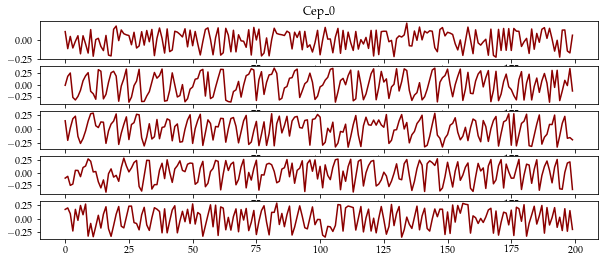

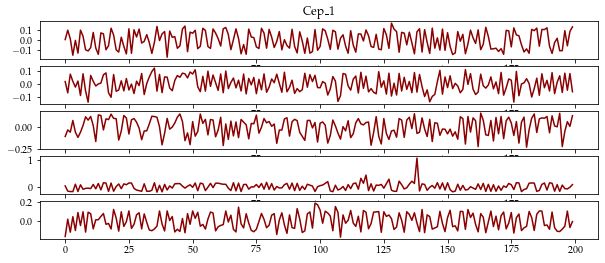

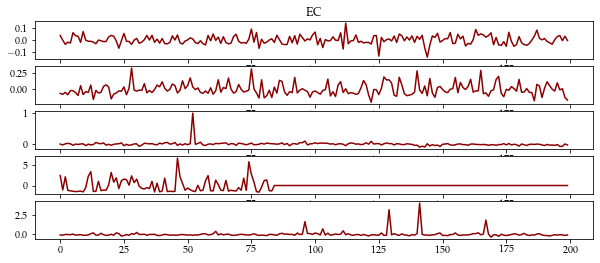

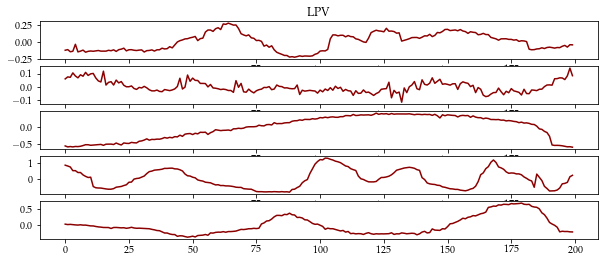

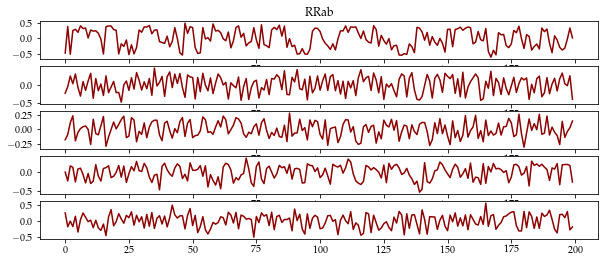

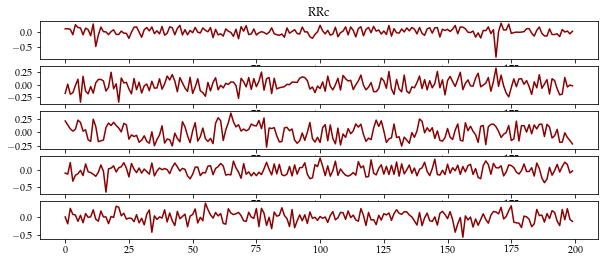

In [154]:
for batch, y in train_batches:
    for l in np.unique(y):
        x = batch['input'][y == l]
        fig, axes = plt.subplots(5, 1, figsize=(10,4))
        for i in range(5):
            axes[i].plot(x[i], color='darkred')
        axes[0].set_title('{}'.format(list(classes_name)[l]))
    break

In [155]:
weigths = './weights/astromer_10022021/finetuning/alcock'
encoder = init_astromer(weigths)

In [172]:
# model = get_mlp(num_cls, encoder)
# model = get_lstm(256, num_cls, 200, dropout=0.4)
model = get_lstm_att(256, num_cls, encoder=encoder, dropout=0.4)
# model.summary()

In [173]:
model.compile(optimizer=Adam(learning_rate=1e-2), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics='accuracy')

In [174]:
estop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
hist = model.fit(train_batches, 
                 epochs=1000,
                 callbacks=[estop],
                 validation_data=val_batches)

Epoch 1/1000
45/45 [==============================] - 36s 695ms/step - loss: 2.6833 - accuracy: 0.2522 - val_loss: 1.7956 - val_accuracy: 0.3593
Epoch 2/1000
45/45 [==============================] - 30s 671ms/step - loss: 2.0508 - accuracy: 0.2610 - val_loss: 1.7390 - val_accuracy: 0.3313
Epoch 3/1000
45/45 [==============================] - 31s 674ms/step - loss: 1.9453 - accuracy: 0.2633 - val_loss: 1.6182 - val_accuracy: 0.3313
Epoch 4/1000
45/45 [==============================] - ETA: 0s - loss: 1.7461 - accuracy: 0.3278

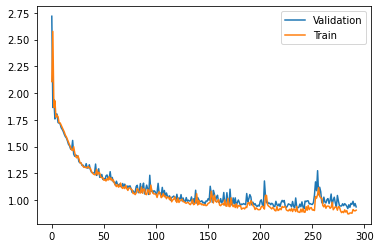

In [115]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_loss'], label='Validation')
plt.plot(hist.history['loss'], label='Train')
plt.legend()

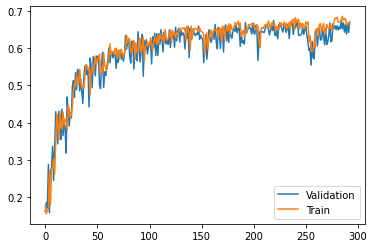

In [116]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.plot(hist.history['accuracy'], label='Train')
plt.legend()

In [117]:
model.save('./my_model_500')

INFO:tensorflow:Assets written to: ./my_model_500/assets


## Testing

In [118]:
import tensorflow as tf
import h5py
import numpy as np

from sklearn.metrics import precision_recall_fscore_support



In [119]:
cd /tf/astromer

/tf/astromer


In [120]:
model = tf.keras.models.load_model('./my_model_500')

In [121]:
metrics = []
for i in range(1, 6):
    with open('./alcock_emb/test_emb_{}.h5'.format(i), 'rb') as file:
        hf = h5py.File(file)
        x_test_time = hf['x'][()]
        y_test = hf['y'][()]
        l_test = hf['l'][()]
        m_test = 1. - hf['m'][()]
    n_classes = len(np.unique(y_test))
    x_test = np.sum(x_test_time*m_test, 1)/l_test[:,None]
    
    indices = np.random.randint(x_test.shape[0], size=750)
    x_test_reduced = x_test[indices]
    y_test_reduced = y_test[indices]
    
    y_pred = model.predict(x_test)
    y_pred_labs = tf.argmax(y_pred, 1)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_labs, average='macro')
    metrics.append([prec, rec, f1])

In [122]:
np.mean(metrics, 0)

array([0.66200063, 0.65999467, 0.65490203])

In [123]:
np.std(metrics, 0)

array([0.00305335, 0.00351824, 0.00300953])

In [46]:

y_test_oneot = tf.one_hot(y_test, n_classes)

In [8]:
import dask.dataframe as dd
import os

In [13]:
batches = './data/embeddings/alcock_records'

In [14]:
observations = dd.read_csv(os.path.join(batches,'*.csv'))

In [16]:
observations.compute()

,oid,label,embs
0,b'1.3443.95',2,[[ 0.2846946 0.27859616 0.29226178 ... 0.2...
1,b'1.3567.1010',0,[[ 0.28489444 0.28023285 0.29222584 ... 0.2...
2,b'1.3691.32',1,[[ 0.2846132 0.27911228 0.29225758 ... 0.2...
3,b'11.8874.36',0,[[ 0.28419593 0.27802372 0.29239047 ... 0.2...
4,b'1.3564.516',2,[[ 0.28459617 0.27790824 0.29232252 ... 0.2...
...,...,...,...
15,b'15.10192.17',3,[[ 0.2842402 0.27915126 0.2923492 ... 0.2...
16,b'2.5388.1150',5,[[ 0.28462884 0.2811178 0.29225647 ... 0.2...
17,b'22.4750.504',5,[[ 0.28273726 0.28988522 0.29268172 ... 0.2...
18,b'22.4992.500',5,[[ 0.2864836 0.25984347 0.29520085 ... 0.2...
